In [50]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

hpi_red = '#b00639'
hpi_blue = '#007a9e'
hpi_yellow = '#ffde94'

def microseconds(x, pos):
    'The two args are the value and tick position'
    return '%i µs' % x
# 
def milliseconds(x, pos):
    'The two args are the value and tick position'
    return '%i ms' % (x*1e-3)

def kilobytes(x, pos):
    'The two args are the value and tick position'
    return '%i kB' % x

def megabytes(x, pos):
    'The two args are the value and tick position'
    return '%i MB' % (x*1e-3)

def plot_all_groups():
    group_columns = get_column_names('custom')
    group_columns.remove('remainder_size')
    group_columns.remove('size')
    group_columns.remove('run_time')
    grouped_data = get_results('custom').groupby(group_columns)
    for group_info in list(grouped_data.groups):
        for i in range(0, len(group_columns)):
            print(group_columns[i] + ": " + str(group_info[i]))
        sub_groups = grouped_data.get_group(group_info).groupby('remainder_size')
        run_time_data = []
        for remainder_size in list(sub_groups.groups):
            run_time_data.append(sub_groups.get_group(remainder_size)['run_time']) 
        plot_labels = ['None', '2', '4', '8', '16'][0:len(run_time_data)]
        boxplot('Table Scan Runtime', run_time_data, plot_labels)
        
def memory_bar(base_sizes, additional_sizes, title, subtitle, labels, file_name):
    sizes = base_sizes + additional_sizes
    size_formatter = FuncFormatter(megabytes)
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(size_formatter)
    plt.rc('xtick', labelsize=11) 
    memory_title = "Memory Consumption"
    ax.set_title(title + '\n' + subtitle)
    ax.yaxis.grid()
    ax.set_axisbelow(True)
    y_step = max(sizes) / 10
    #plt.yticks(np.arange(0, max(sizes)*1.1, y_step))
    edgecolors = ['black'] * len(sizes)
    bar1 = plt.bar(range(len(base_sizes)), base_sizes, width=1/1.5, color=hpi_red, tick_label=labels, linewidth=1.0, \
            edgecolor=edgecolors, label="Column Data")
    bar2 = plt.bar(range(len(additional_sizes)), additional_sizes, bottom=base_sizes, width=1/1.5, color=hpi_yellow, \
            tick_label=labels, linewidth=1.0, edgecolor=edgecolors, label="Filter/Index")
    plt.legend(handles=[bar2, bar1])
    plt.savefig('plots/table_scan/{}.pgf'.format(file_name + "_memory"))
    plt.savefig('plots/table_scan/{}.pdf'.format(file_name + "_memory"))
    plt.show()

def memory_bar_full(value, value_filter, dictionary, art, btree, title, subtitle, file_name): 
    value_size = value['size'].iloc[0]
    value_filter_size = value_filter['size'].iloc[0]
    dict_size = dictionary['size'].iloc[0]
    art_size = art['size'].iloc[0]
    btree_size = btree['size'].iloc[0]
        
    base_sizes = [value_size, value_size, dict_size, dict_size, value_size]
    additional_sizes = [0, value_filter_size - value_size, 0, art_size - dict_size, btree_size - value_size]
    
    labels = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'ART', 'B-Tree']
    memory_bar(base_sizes, additional_sizes, title, subtitle, labels, file_name)
    
def memory_bar_small(value, value_filter, title, subtitle, file_name):
    value_size = value['size'].iloc[0]
    value_filter_size = value_filter['size'].iloc[0]

    base_sizes = [value_size, value_size]
    additional_sizes = [0, value_filter_size - value_size]
    
    labels = ['Value\nColumn', 'Value +\nFilter']
    memory_bar(base_sizes, additional_sizes, title, subtitle, labels, file_name)
    
def runtime_bar(title, subtitle, data, labels, file_name, unit='milli', start_at_zero=True):
    runtimes = []
    for series in data:
        runtimes.append(np.median(series['run_time']))
    
    formatter = FuncFormatter(microseconds)
    if unit == 'milli':
        formatter = FuncFormatter(milliseconds)
    elif unit == 'micro':
        formatter = FuncFormatter(microseconds)
    else: 
        print('unknown unit')

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    plt.rc('xtick', labelsize=11) 
    ax.yaxis.grid()
    ax.set_axisbelow(True)
    edgecolors = ['black'] * len(runtimes)
    plt.bar(range(len(runtimes)), runtimes, width=1/1.5, color=hpi_blue, tick_label=labels, linewidth=1.0, edgecolor=edgecolors)
    
    #bp_dict = plt.boxplot(data, labels=labels, showfliers=False)
    #for line in bp_dict['medians']:
    #    # get position data for median line
    #    print(line)
    #    x, y = line.get_xydata()[1] # top of median line
    #    # overlay median value
    #    plt.text(x, y - 100, '%d' % y, horizontalalignment='center') # draw above, centered
    
    plt.title(title + '\n' + subtitle)
    #plt.xlabel('remainder size')
    #plt.ylabel('run time')
    if start_at_zero:
        ax.set_ylim(ymin=0)
    plt.savefig('plots/table_scan/{}.pgf'.format(file_name + "_runtime"))
    plt.savefig('plots/table_scan/{}.pdf'.format(file_name + "_runtime"))
    plt.show()
    
def runtime_box(title, subtitle, data, labels, file_name, unit='milli', start_at_zero=True): 
    runtimes = []
    for series in data:
        runtimes.append(series['run_time'])
    
    formatter = FuncFormatter(microseconds)
    if unit == 'milli':
        formatter = FuncFormatter(milliseconds)
    elif unit == 'micro':
        formatter = FuncFormatter(microseconds)
    else: 
        print('unknown unit')

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    plt.rc('xtick', labelsize=8) 
    ax.yaxis.grid()
    ax.set_axisbelow(True)
    plt.boxplot(runtimes, labels=labels, showfliers=False)
    
    #bp_dict = plt.boxplot(data, labels=labels, showfliers=False)
    #for line in bp_dict['medians']:
    #    # get position data for median line
    #    print(line)
    #    x, y = line.get_xydata()[1] # top of median line
    #    # overlay median value
    #    plt.text(x, y - 100, '%d' % y, horizontalalignment='center') # draw above, centered
    
    plt.title(title + "\n" + subtitle)
    #plt.xlabel('remainder size')
    plt.ylabel('run time')
    if start_at_zero:
        ax.set_ylim(ymin=0)
    plt.savefig('plots/table_scan/{}.pgf'.format(file_name + "_runtime"))
    plt.savefig('plots/table_scan/{}.pdf'.format(file_name + "_runtime"))
    plt.show()
    
def get_column_names(benchmark): 
    table_info = json.load(open(benchmark + '_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names
    
def get_results(benchmark):
    return pd.read_csv(benchmark + '_results.csv', header=None, names=get_column_names(benchmark))

#table_name
#column_name
#data_type
#row_count
#chunk_size
#pruning_rate
#selectivity
#quotient_size
#remainder_size
#dictionary
#btree
#art
#size
#run_time

def select(data, table_name=None, column_name=None, data_type=None, row_count=None, chunk_size=None, \
           quotient_size=None, remainder_size=None, dictionary=None, btree=None, art=None, pruning_rate=None, \
           selectivity=None):
    if table_name == None:
        table_name = data["table_name"].iloc[0]
    if column_name == None:
        column_name = data["column_name"].iloc[0]
    if data_type == None:
        data_type = data["data_type"].iloc[0]
    if row_count == None:
        row_count = data["row_count"].iloc[0]
    if chunk_size == None:
        chunk_size = data["chunk_size"].iloc[0]
    if quotient_size == None:
        quotient_size = data["quotient_size"].iloc[0]
    if remainder_size == None:
        remainder_size = data["remainder_size"].iloc[0]
    if dictionary == None:
        dictionary = data["dictionary"].iloc[0]
    if btree == None:
        btree = data["btree"].iloc[0]
    if art == None:
        art = data["art"].iloc[0]
    if pruning_rate == None:
        pruning_rate = data["pruning_rate"].iloc[0]
    if selectivity == None:
        selectivity = data["selectivity"].iloc[0]
        
    return data[(data.table_name == table_name) &
                (data.column_name == column_name) &
                (data.data_type == data_type) &
                (data.row_count == row_count) &
                (data.chunk_size == chunk_size) &
                (data.quotient_size == quotient_size) & 
                (data.remainder_size == remainder_size) & 
                (data.dictionary == dictionary) & 
                (data.btree == btree) & 
                (data.art == art) &
                (data.pruning_rate == pruning_rate) & 
                (data.selectivity == selectivity)
                ]
def btree(data):
    return select(data, remainder_size=0, dictionary=0, btree=1, art=0)

def art(data):
    return select(data, remainder_size=0, dictionary=1, btree=0, art=1)

def value(data):
    return select(data, remainder_size=0, dictionary=0, btree=0, art=0)

def value_filter(data):
    return select(data, remainder_size=2, dictionary=0, btree=0, art=0)

def dictionary(data):
    return select(data, remainder_size=0, dictionary=1, btree=0, art=0)

def dict_filter(data):
    return select(data, remainder_size=2, dictionary=1, btree=0, art=0)

def evaluate_bar(data_name, data=None):
    if data is None:
        data = get_results(data_name)
    
    btree_data        = btree(data)
    art_data          = art(data)
    value_filter_data = value_filter(data)
    dictionary_data   = dictionary(data)
    dict_filter_data  = dict_filter(data)
    value_column_data = value(data)

    plot_data1 = [value_column_data, value_filter_data, dictionary_data, art_data, btree_data]
    plot_data2 = [value_column_data, value_filter_data]
    labels1 = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'ART', 'B-Tree']
    labels2 = ['Value\nColumn', 'Value +\nFilter']
    
    chunk_size = data['chunk_size'].iloc[0]
    row_count = data['row_count'].iloc[0]
    table_name = data['table_name'].iloc[0]
    column_name = data['column_name'].iloc[0]
    
    title = table_name + '::' + column_name + ' Scan Runtime'
    subtitle = 'Chunk Size: ' + str(chunk_size) + ', Row Count: ' + str(row_count)
    memory_bar_full(*plot_data1, title, subtitle, data_name + "_scan_bar_full")
    runtime_bar(title, subtitle, plot_data1, labels1, data_name + "_scan_bar_full")
    
    memory_bar_small(*plot_data2, title, subtitle, data_name + "_scan_bar_small")
    runtime_bar(title, subtitle, plot_data2, labels2, data_name + "_scan_bar_small")
    
def evaluate_box(data_name, data=None):
    if data is None:
        data = get_results(data_name)
    
    btree_data        = btree(data)
    art_data          = art(data)
    value_filter_data = value_filter(data)
    dictionary_data   = dictionary(data)
    dict_filter_data  = dict_filter(data)
    value_column_data = value(data)
    
    plot_data1 = [value_column_data, value_filter_data, dictionary_data, art_data, btree_data]
    plot_data2 = [value_column_data, value_filter_data]
    labels1 = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'ART', 'B-Tree']
    labels2 = ['Value\nColumn', 'Value +\nFilter']
    
    table_name = data['table_name'].iloc[0]
    column_name = data['column_name'].iloc[0]
    chunk_size = data['chunk_size'].iloc[0]
    row_count = data['row_count'].iloc[0]
    
    title = table_name + '::' + column_name + ' Scan Runtime'
    subtitle = 'Chunk Size: ' + str(chunk_size) + ', Row Count: ' + str(row_count)
    
    memory_bar_full(*plot_data1, title, subtitle, data_name + "_scan_bar_full")
    runtime_box(title, subtitle, plot_data1, labels1, data_name + "_scan_box_full")
    memory_bar_small(*plot_data2, title, subtitle, data_name + "_scan_bar_small")
    runtime_box(title, subtitle, plot_data2, labels2, data_name + "_scan_box_small")
    
def filter_comparison_value_column(data_name, data=None):
    if data is None:
        data = get_results(data_name)
    series0 = select(data, remainder_size=0, dictionary=0, btree=0, art=0)
    series2 = select(data, remainder_size=2, dictionary=0, btree=0, art=0)
    series4 = select(data, remainder_size=4, dictionary=0, btree=0, art=0)
    series8 = select(data, remainder_size=8, dictionary=0, btree=0, art=0)
    plot_data = [series0, series2, series4, series8]
    labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
    data_type = data['data_type'].iloc[0]
    chunk_size = data['chunk_size'].iloc[0]
    row_count = data['row_count'].iloc[0]
    title = 'Table Scan Runtime: ' + data_type + 'Value Column Scan'
    subtitle = 'Chunk Size: ' + str(chunk_size) + ', Row Count: ' + str(row_count)
    sizes = [series0['size'].iloc[0], series2['size'].iloc[0], series4['size'].iloc[0], series8['size'].iloc[0]]
    memory_bar(sizes, [0, 0, 0, 0], title, subtitle, labels, data_name + "_scan_" + data_type + "_value")
    runtime_box(title, subtitle, plot_data, labels, data_name + "_scan_" + data_type + "_value")
    
def filter_comparison_dict_column(data_name, data=None):
    if data is None:
        data = get_results(data_name)
    series0 = select(data, remainder_size=0, dictionary=1, btree=0, art=0)
    series2 = select(data, remainder_size=2, dictionary=1, btree=0, art=0)
    series4 = select(data, remainder_size=4, dictionary=1, btree=0, art=0)
    series8 = select(data, remainder_size=8, dictionary=1, btree=0, art=0)
    plot_data = [series0, series2, series4, series8]
    labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
    chunk_size = data['chunk_size'].iloc[0]
    row_count = data['row_count'].iloc[0]
    data_type = data['data_type'].iloc[0]
    title = 'Table Scan Runtime: ' + data_type + 'Dictionary Column Scan'
    subtitle = 'Chunk Size: ' + str(chunk_size) + ', Row Count: ' + str(row_count)
    sizes = [series0['size'].iloc[0], series2['size'].iloc[0], series4['size'].iloc[0], series8['size'].iloc[0]]
    memory_bar(sizes, [0, 0, 0, 0], title, subtitle, labels, data_name + "_scan_" + data_type + "_dict")
    runtime_box(title, subtitle, plot_data, labels, data_name + "_scan_" + data_type + "_dict")
    

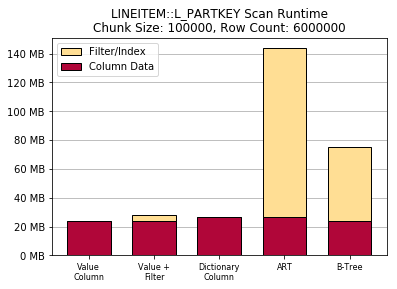

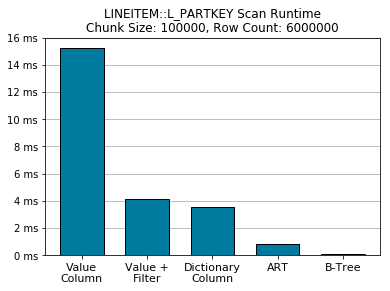

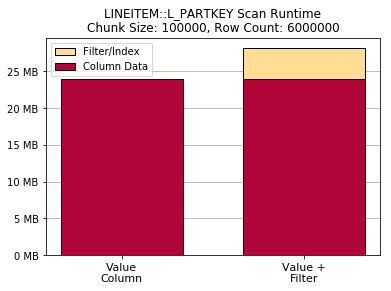

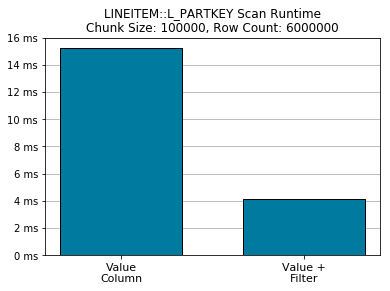

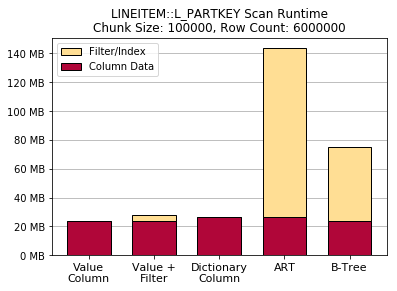

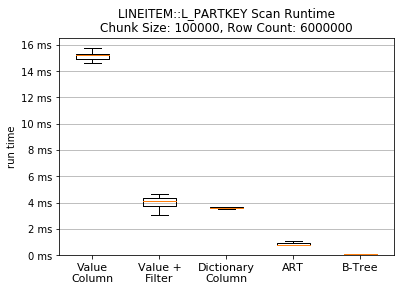

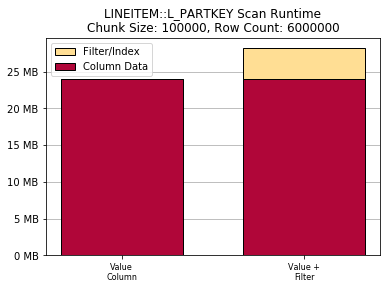

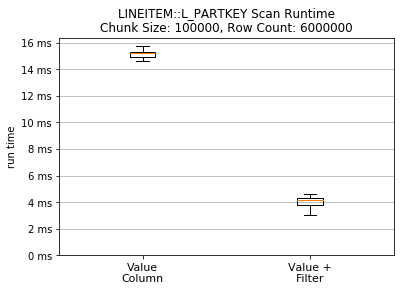

In [33]:
evaluate_bar('jcch')
evaluate_box('jcch')

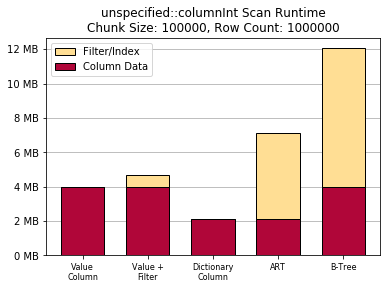

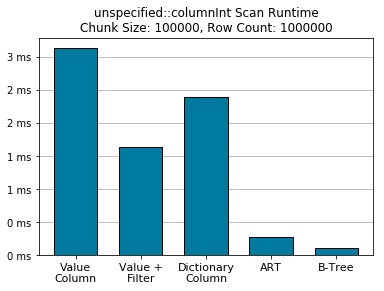

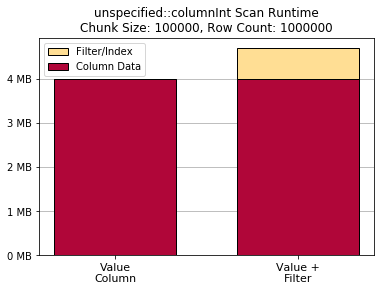

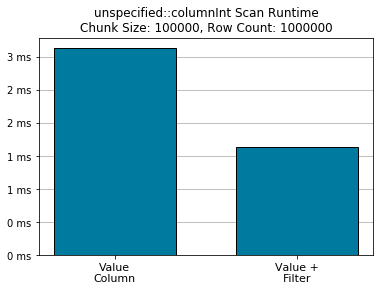

In [29]:
data = get_results('custom')
evaluate_bar('custom', data=data[data.pruning_rate == 0.5])

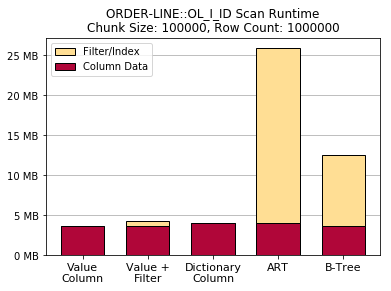

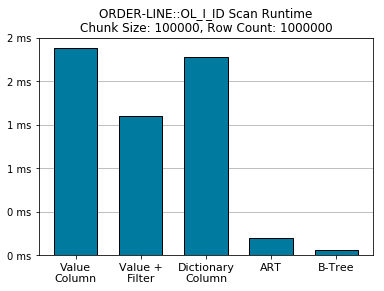

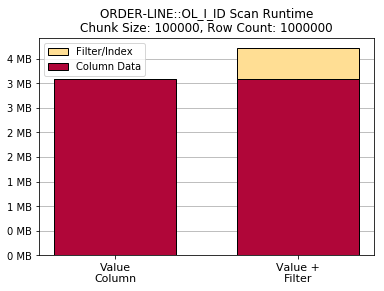

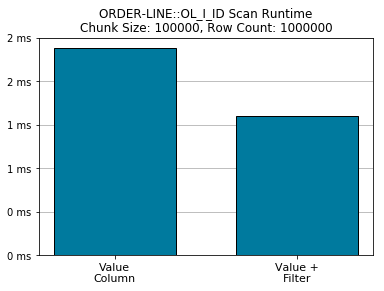

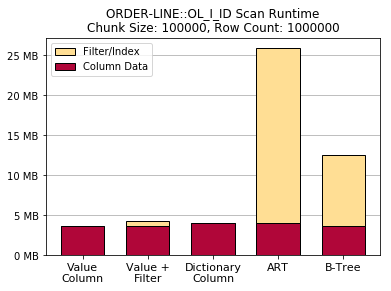

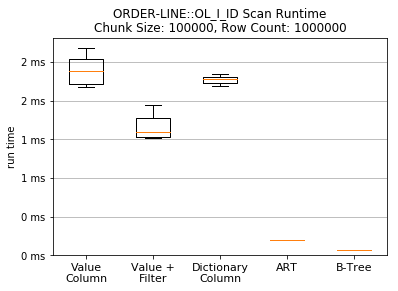

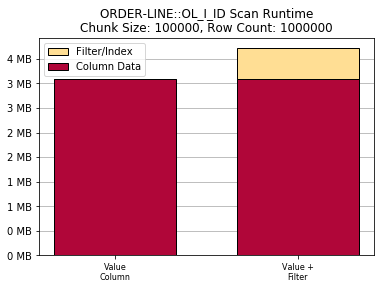

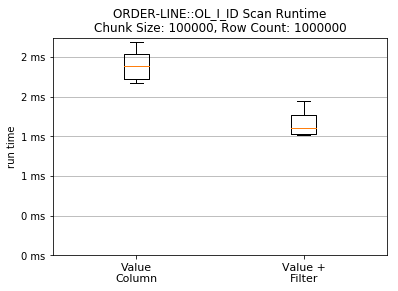

In [30]:
evaluate_bar('tpcc')
evaluate_box('tpcc')

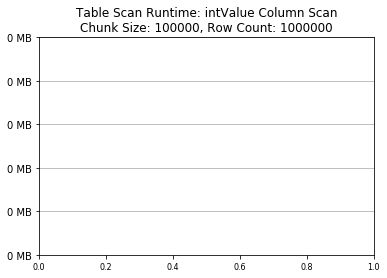

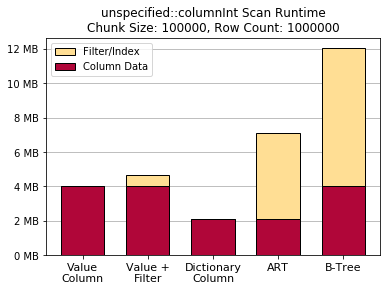

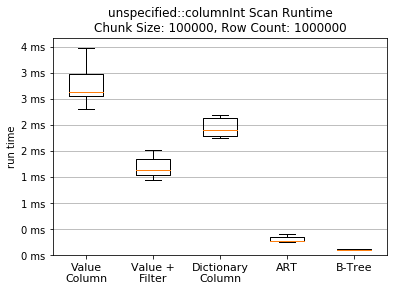

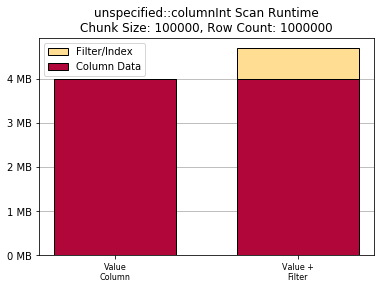

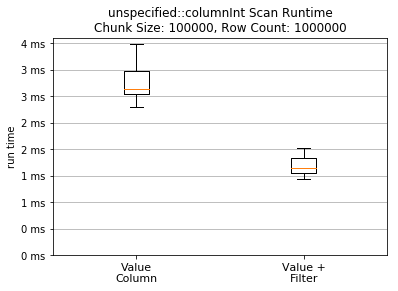

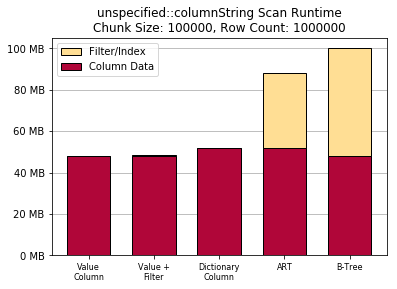

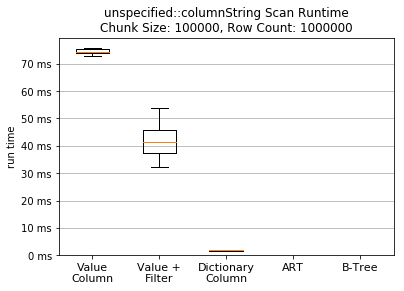

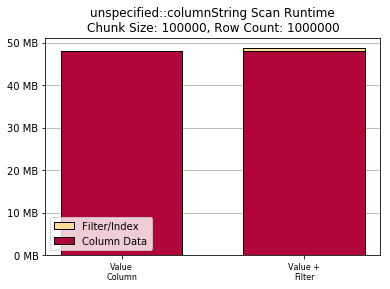

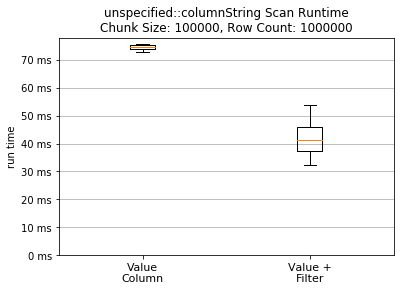

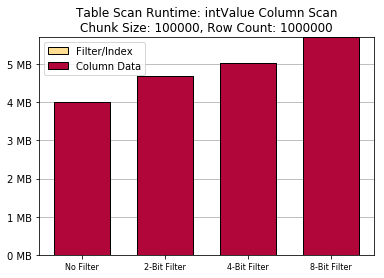

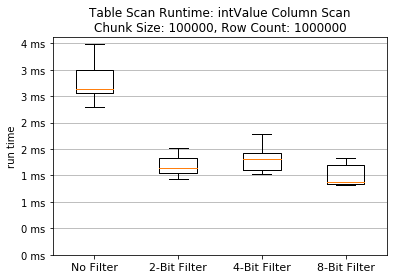

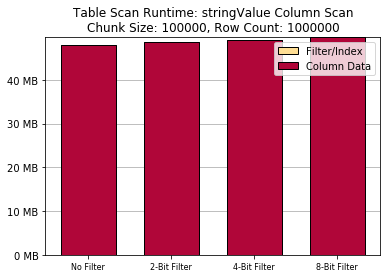

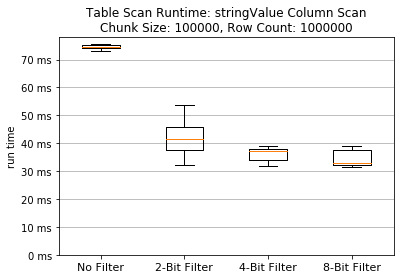

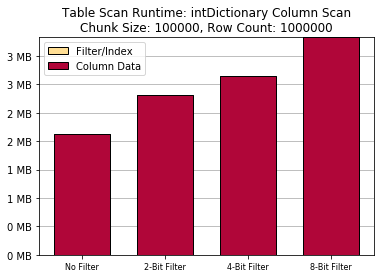

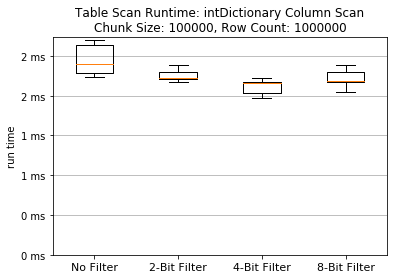

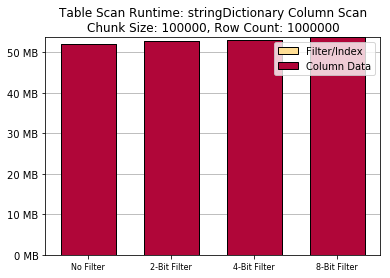

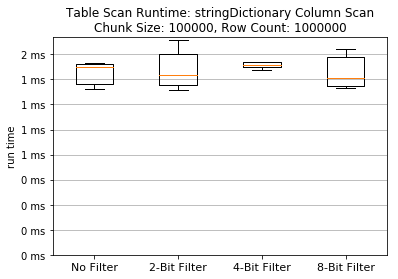

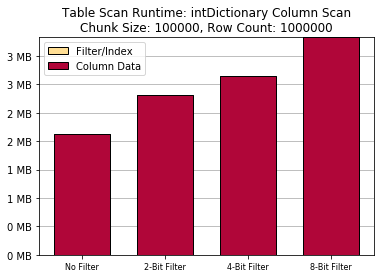

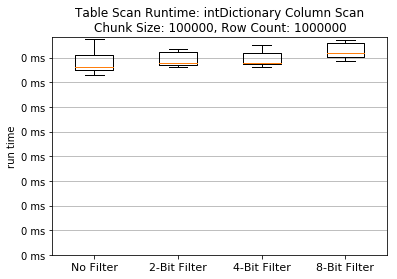

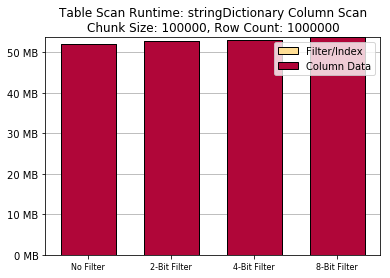

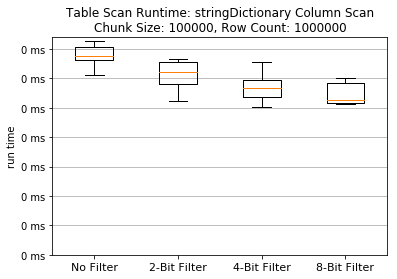

In [51]:
custom_data = get_results('custom')

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'int')]
evaluate_box('custom', data)

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'string')]
evaluate_box('custom', data)

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'int')]
filter_comparison_value_column("custom", data)

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'string')]
filter_comparison_value_column("custom", data)

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'int')]
filter_comparison_dict_column("custom", data)

data = custom_data[(custom_data.pruning_rate == 0.5) & (custom_data.data_type == 'string')]
filter_comparison_dict_column("custom", data)

data = custom_data[(custom_data.pruning_rate == 1.0) & (custom_data.data_type == 'int')]
filter_comparison_dict_column("custom", data)

data = custom_data[(custom_data.pruning_rate == 1.0) & (custom_data.data_type == 'string')]
filter_comparison_dict_column("custom", data)